In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import scipy as sc
import os
from astropy.io import fits,ascii
from sklearn import preprocessing
from sklearn.metrics import classification_report, confusion_matrix
from keras import backend as K
import GetLightcurves as gc
from scipy.signal import find_peaks,lombscargle


In [28]:
id1, true_label1, pred_label1 = gc.read_tfr_record('../../training_data/jointanalysis',['id','true_label','pred_label'],
    ['b','ar','ar'],[tf.string,tf.bool, tf.float32])
id2, true_map2, pred_map2, pred_label2 = gc.read_tfr_record('../../training_data/jointanalysis2',
    ['id','true_map','pred_map','pred_class'],
    ['b','ar','ar','ar'],[tf.string,tf.bool,tf.float32,tf.bool])
ip, idr, loc, glob,lb_temp = gc.read_tfr_record('../../training_data/total_tstest', ['input','id','local','global','label'],
    ['ar','b','ar','ar','ar'], [tf.float32, tf.string, tf.float32, tf.float32,tf.bool])

b'0103458621' [False  True False]
b'0121645641' [ True False False]
b'0113916671' [False  True False]


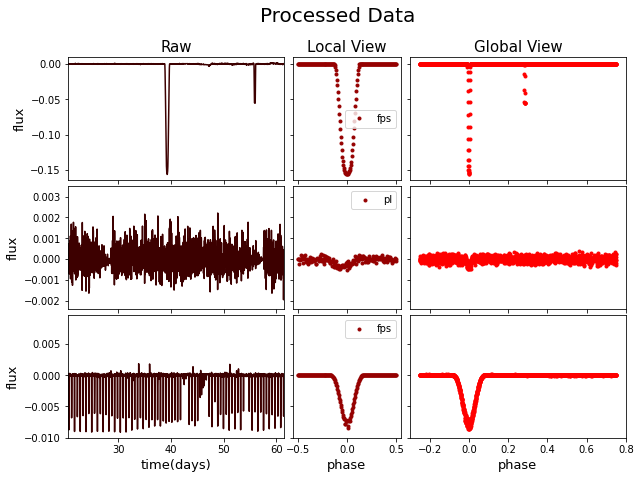

In [49]:

fig, ax=plt.subplots(3,3,figsize=(10,7),gridspec_kw={'width_ratios': [2,1,2]},sharex='col', sharey='row')
ch=[6,4,16]
#ch=[16,17,18]
i=0
plt.suptitle('Processed Data', size=20)
tarr=np.arange(0,4000,1)*29.4/1440
pharr=np.linspace(-0.25,0.75,2000)
pharrl=np.linspace(-0.5,0.5,200)
ax[0][0].set_title('Raw', size=15)
ax[0][1].set_title('Local View', size=15)
ax[0][2].set_title('Global View', size=15)
ax[2][0].set_xlabel('time(days)', size=13)
ax[2][1].set_xlabel('phase', size=13)
ax[2][2].set_xlabel('phase', size=13)
for k in range(0,3):
    if(lb_temp[ch[i]][0]): lb='pl'
    else: lb='fps'
    ax[k][0].plot(tarr,ip[ch[i]], color='#3d0000')
    ax[k][1].plot(pharrl,loc[ch[i]],label=lb, marker='.', ls='none',color='#950101')
    ax[k][2].plot(pharr,glob[ch[i]], marker='.', ls='none', color='#ff0000')
    ax[k][0].set_xlim(1000*29.4/1440,3000*29.4/1440)
    ax[k][0].set_ylabel('flux', size=13)
    ax[k][1].legend()
    print(idr[ch[i]], lb_temp[ch[i]])
    i+=1

plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.savefig('fprez_comb.png')
plt.show()

In [4]:
idf1  = np.asarray([str(id1[i])[2:13] for i in range(0,len(id1))])
idf2  = np.asarray([str(id2[i])[2:13] for i in range(0,len(id2))])
idfr  = np.asarray([str(idr[i])[2:13] for i in range(0,len(idr))])


In [7]:
#comparision array
arr=[]
#print(pred_label2[:10])
for i in range(0,len(idf1)):
    idstr=idf1[i]
    #if(idstr[-1]!='1'): continue
    t1 = np.argmax(np.asarray(pred_label1[i]))
    t3 = np.argmax(np.asarray(true_label1[i]))
    if(np.all(np.asarray(pred_label2[i])==[1,1])): t2 = np.argmax(np.asarray(true_label1[i]))
    else: t2 = np.argmax(np.asarray(pred_label2[i]))
    arr.append([t1,t2,t3])

#print(arr)
arr=np.asarray(arr)
#print(arr[:10])
sumarr=np.asarray([np.sum(el) for el in arr])
#print(sumarr)
tot1=np.asarray([np.all(el==np.asarray([0,1,1])) for el in arr]).sum() + np.asarray([np.all(el==np.asarray([1,0,0])) for el in arr]).sum()
tot2=np.asarray([np.all(el==np.asarray([1,0,1])) for el in arr]).sum() + np.asarray([np.all(el==np.asarray([0,1,0])) for el in arr]).sum()
tot3=np.asarray([np.all(el==np.asarray([1,1,0])) for el in arr]).sum() + np.asarray([np.all(el==np.asarray([0,0,1])) for el in arr]).sum()
print(tot1/len(sumarr), tot2/len(sumarr), tot3/len(sumarr))
#print(arr,tot1)
#print(np.asarray(sumarr==0).sum()/len(sumarr) + np.asarray(sumarr==2).sum()/len(sumarr))
print(np.asarray(sumarr==0).sum()/len(sumarr) + np.asarray(sumarr==3).sum()/len(sumarr))

cm=confusion_matrix(arr[:,0],arr[:,1])
print(cm/cm.sum())

0.07949029126213593 0.16080097087378642 0.055825242718446605
0.7038834951456311
[[0.28398058 0.12196602]
 [0.11832524 0.47572816]]


265


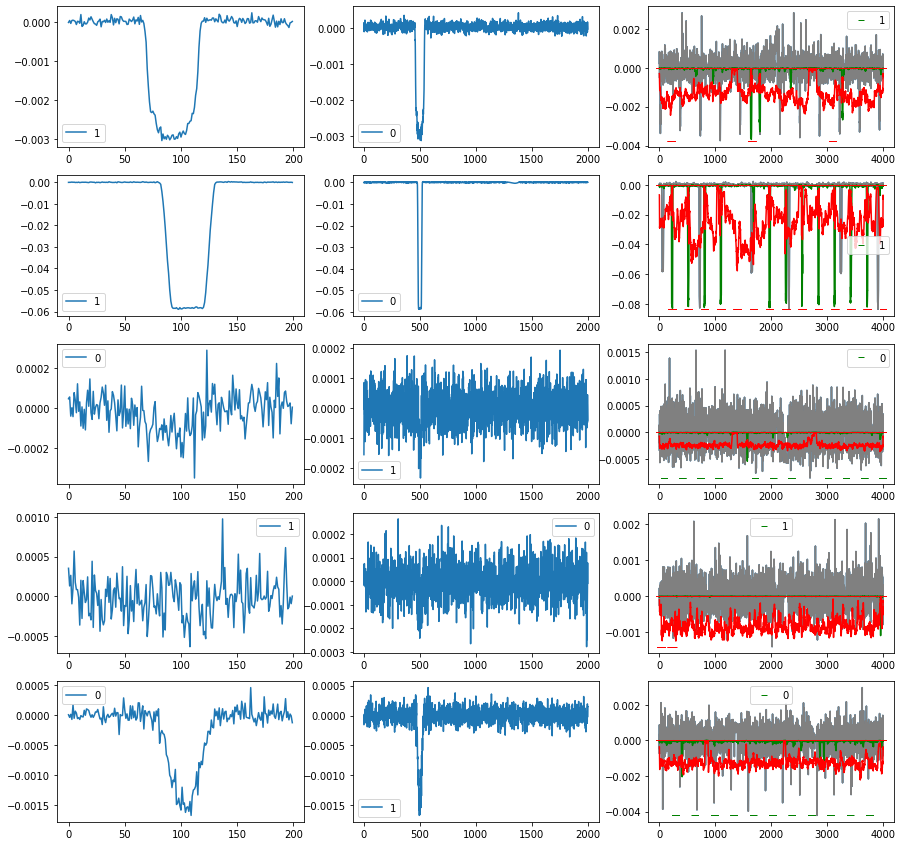

In [9]:
#both wronged
wr_ind = [i for i in range(len(arr)) if np.all(arr[i]==np.asarray([1,0,1])) or np.all(arr[i]==np.asarray([0,1,0]))]
print(len(wr_ind))
np.random.shuffle(wr_ind)
fig, ax= plt.subplots(5,3, figsize=(15,15))
for i in range(0,5):
    ax[i][2].plot(ip[wr_ind[i]])
    mp = pred_map2[wr_ind[i]].reshape(4000,3)
    tmp = true_map2[wr_ind[i]].reshape(4000,3)
    minim=min(ip[wr_ind[i]])
    ax[i][0].plot(loc[wr_ind[i]],label=arr[wr_ind[i],0])
    ax[i][1].plot(glob[wr_ind[i]],label=arr[wr_ind[i],1])

    ax[i][2].plot(ip[wr_ind[i]],  color='gray')
    ax[i][2].plot(mp[:,0]*minim,color='green')
    ax[i][2].plot(mp[:,1]*minim,color='red')
    ax[i][2].plot(tmp[:,0]*minim,color='green',ls='none', marker='_',label=arr[wr_ind[i],2])
    ax[i][2].plot(tmp[:,1]*minim,color='red',ls='none', marker='_')
    
    ax[i][0].legend()
    ax[i][1].legend()
    ax[i][2].legend()
    



In [38]:
PATH='../../processed_directories/new_pl/'
PATH2='../../processed_directories/expand_test_result_av/'
FILEPATH_FPS="E:\Masters_Project_Data\\alienworlds_fps\\"

In [3]:

ALPHA = 0.8
GAMMA = 3

def FocalLoss(targets, inputs, alpha=ALPHA, gamma=GAMMA):    
    
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    
    BCE = K.binary_crossentropy(targets, inputs)
    BCE_EXP = K.exp(-BCE)
    focal_loss = K.mean(K.pow((1-BCE_EXP), gamma) * BCE)
    
    return focal_loss

def log_cosh_dice_loss(y_true, y_pred):
        x = generalized_dice_coeff(y_true, y_pred)
        return tf.math.log((tf.exp(x) + tf.exp(-x)) / 2.0)

def bce_dice_loss(y_true, y_pred):
    loss = keras.losses.binary_crossentropy(y_true, y_pred)*0.5 + log_cosh_dice_loss(y_true, y_pred)
    return loss

def generalized_dice_coeff(y_true, y_pred):
    # Compute weights: "the contribution of each label is corrected by the inverse of its volume"
    w = tf.reduce_sum(y_true,(0,1))
    w= w/tf.linalg.norm(w)
    w = 1 / (w  + 0.00001)
    #w = 1 - w
    #w = w**2
    w=tf.cast(w,tf.float32)


    numerator = y_true * y_pred
    numerator = w * K.sum(numerator, (0, 1))
    numerator = K.sum(numerator)

    denominator = y_true + y_pred
    denominator = w * K.sum(denominator, (0, 1))
    denominator = K.sum(denominator)

    gen_dice_coef = numerator / denominator

    return 1 - 2 * gen_dice_coef

def focal_dice_loss(y_true, y_pred):
    loss = FocalLoss(y_true, y_pred) + 1*log_cosh_dice_loss(y_true, y_pred)
    return loss

def remove_nan(red_flux,bins):
    #for i in range(0,len(red_flux)):
    #    if(np.isnan(red_flux[i])):
    #        t=1
    #        try:
    #            while(np.isnan(red_flux[i-t]) or np.isnan(red_flux[i+t])):    
    #                if(i-t == 0):
    #                    red_flux[i]=red_flux[i+t]
    #                    break
    #                elif(i+t == bins-1): 
    #                    red_flux[i]=red_flux[i-t]
    #                    break
    #                t+=1
    #            red_flux[i]=(red_flux[i-t]+red_flux[i+t])/2
    #        except:
    #            red_flux[i]=0
    for i in range(0,len(red_flux)):
        if np.isnan(red_flux[i]):
            red_flux[i]=0
#print(tfa.losses.SigmoidFocalCrossEntropy(Ytest, Ytest))


In [164]:
#this chunk will contain modules to find lomb scargle peak periods in the NN...
def open_the_file_and_chunk(filepath, hdu_no, dil_rate):
    hdu = fits.open(filepath)
    flux=hdu[hdu_no].data['LC_DETREND']
    #flux=hdu[len(hdu)-1].data['RESIDUAL_LC']
    tdurs = [hdu[n].header['TPERIOD'] for n in range(1,len(hdu)-1)]
    
    remove_nan(flux,4000)
    inc=4000*dil_rate
    chunks = np.asarray([flux[np.arange(i,i+inc,dil_rate)] for i in range(0,len(flux)-inc, inc)])
    return(chunks, tdurs)

def chunk_file_from_pd(filepath, dil_rate):
    input, map=gc.read_tfr_record(filepath, ['input','mask'],['ar','ar'], [tf.float32, tf.bool])
    
    map=np.asarray(map).reshape(len(input),4000,3)
    input=np.concatenate(np.asarray(input),axis=0)
    map=np.concatenate(np.asarray(map),axis=0)
    
    inc=4000*dil_rate
    chunks = np.asarray([input[np.arange(i,i+inc,dil_rate)] for i in range(0,len(input)-inc, inc)])
    mpch = np.asarray([map[np.arange(i,i+inc,dil_rate)] for i in range(0,len(map)-inc, inc)])
    return(chunks, mpch)

def periodogram_and_freq(chunks, minp, maxp,ch=0, prec=10000):
    p = np.linspace(minp,maxp,prec)
    f = 2*np.pi /p
    tot = np.concatenate(chunks, axis=0)
    #thres = np.mean(tot)
    #tot = np.asarray([1 if(el>thres) else 0 for el in tot])
    #print(tot.shape, thres)
    print(tot.shape)
    tot = [np.argmax(el) for el in tot]
    print(len(tot))
    tot = np.asarray(np.asarray(tot)==ch)
    print(tot)
    
    predp = lombscargle(np.arange(0,len(tot))*29.4/1440, tot,f, normalize=True)
    return(p, predp)

def what_the_peak(per, predp, ip, ch=0,thres=1):
    newp=[]
    h = np.median(predp)+thres*np.std(predp)
    totip = np.concatenate(ip, axis=0)

    plp, _ = find_peaks(np.asarray(predp), height=h, distance=40)
    peakf = per[plp]
    print(peakf)
    peakinfo = np.asarray([predp[plp],per[plp]])
    sortedArr = peakinfo [ :, peakinfo[0].argsort()]
    mn = np.mean(totip)
    #print(sortedArr)
    other = np.arange(0,len(totip),1)
    for p in np.flip(np.asarray(sortedArr[1])):
        #print(p)
        mask = color_a_peak_v2(totip, p)
        nother = np.setdiff1d(other,mask)
        #tmn = np.mean(totip[other])
        print(p,len(other),len(nother),(len(other)-len(nother))/len(mask))
        if((len(other)-len(nother))/len(mask) > 0.25):
            newp.append(p)
            other = nother
        #print(mn, tmn)
        #if(tmn>mn): 
        #    mn = tmn
        #    newp.append(p)
        #else: continue
    return(newp)
    #choose good ones.


def plot_a_map(input, map):
    totip = np.concatenate(input)
    totop = np.concatenate(map, axis=0)

    counts=np.asarray([np.argmax([el[0],el[1],el[2]]) for el in totop])
    pl=np.where(counts==0)[0]
    fps=np.where(counts==1)[0]
    bkg=np.where(counts==2)[0]

    m=min(totip)
    plt.figure(figsize=(10,5))
    plt.title('Total Segmentation Map')
    plt.xlabel('time (days)')
    plt.ylabel('flux')
    #plt.plot(np.arange(0,len(totip))*29.4/1440,totop[:,0])
    #plt.plot(np.arange(0,len(totip))*29.4/1440,totop[:,1])
    plt.plot(np.asarray(bkg)*29.4/1440,totip[bkg], color='#a4b3b6', marker='.', ls='none', label='bkg')
    plt.plot(np.asarray(fps)*29.4/1440,totip[fps], color='#44318d', marker='.', ls='none', label='fps')
    plt.plot(np.asarray(pl)*29.4/1440,totip[pl], color='#d83f87', marker='.', ls='none', label='pl')
    plt.legend()
    
def plot_a_peak(perarr, input, map, shift,num1=1,num2=1, scale=[10], thres=0.5):
    flag = 0
    if(len(perarr)==1): flag=1
    fig, ax = plt.subplots(num1,num2,figsize=(10,10))
    plt.suptitle('Sample Phasefolds', size=20)
    i=0
    j=0
    for el in range(len(perarr)):
        #print(perarr)
        per = int(perarr[el] * 24 *60/29.4)
        bias = int(shift[el]*per)
        totip = np.concatenate(input, axis=0)
        totmp = np.concatenate(map, axis=0)
        phfip = [totip[i:i+per] for i in range(bias,len(totip)-per,per)]
        phfmap = np.asarray([totmp[i:i+per] for i in range(bias,len(totmp)-per,per)])

        phfmap = np.mean(phfmap, axis=0)
        print(len(phfmap))
        phfip = np.mean(phfip, axis=0)
        box = np.ones(3)/3
        phfip = np.convolve(phfip, box, mode='same')
        md = np.median(phfip)
        st = min(phfip)

        phaseax=np.linspace(0,1,len(phfmap))
        print(md, st)
        ker=np.ones(10)/10
        if(flag==1):
            #ax.plot(phaseax,phfmap, label='map')
            ax.plot(phaseax,np.convolve(phfip*scale[el], ker, mode='same'), label='input', marker='.',ls='none', color='#2a1b3d')
            ax.set_title('period:'+"{:.2f}".format(perarr[el]), size='14')
            #ax.plot(phaseax,(md+thres*st)*np.ones(len(phfip))*scale[el])
            #print('md:',md)
            ax.set_xlabel('Time(Days)', size='13')
            ax.set_ylabel('Flux', size='13')
            ax.legend()
        elif(num2==1):
            #ax[i].plot(phaseax,phfmap, label='map')
            ax[i].plot(phaseax,np.convolve(phfip*scale[el], ker, mode='same'), label='input', marker='.',ls='none', color='#2a1b3d')
            ax[i].set_title('period:'+ "{:.2f}".format(perarr[el]), size='14')
            #ax[i].plot(phaseax,(md+thres*st)*np.ones(len(phfip))*scale[el])
            ax[i].set_xlabel('Time(Days)', size='13')
            ax[i].set_ylabel('Flux',size='13')
            ax[i].legend()
        else:
            #ax[i].plot(phaseax,phfmap, label='map')
            ax[i][j].plot(phaseax,np.convolve(phfip*scale[el], ker, mode='same'), label='input', marker='.',ls='none', color='#2a1b3d')
            ax[i][j].set_title('period:'+ "{:.2f}".format(perarr[el]), size='14')
            ax[i][j].plot(phaseax,(md+thres*st)*np.ones(len(phfip))*scale[el])
            ax[i][j].set_xlabel('Time(Days)', size='13')
            ax[i][j].set_ylabel('Flux',size='13')
            ax[i][j].legend()
        j+=1
        if(j==num2):
            j=0
            i+=1
        if(i==num1): break

def color_a_peak(chunks, peakarr, thres):
    mainmask=[]
    mno=1
    input = np.concatenate(chunks)
    k=0
    for el in peakarr:
        req_p = int(el * 24 *60/29.4)
        phf = np.asarray([input[i:i+req_p] for i in range(0,len(input)-req_p,req_p)])
        phf = np.mean(phf, axis = 0)
        md = np.median(phf)
        std = min(phf)
        
        pts = np.asarray([i for i in range(len(phf)) if(phf[i]<md+thres[k]*std)])
        newpts = pts
        x=len(phf)
        k+=1
        while(x<68000):
            #print(x, len(pts))
            #print(len(pts+x*np.ones(len(pts))))
            newpts = np.concatenate([newpts,np.asarray(pts+x*np.ones(len(pts)),dtype='int')])
            x+=len(phf)
        newpts = [el for el in newpts if el<68000] 
        mainmask.append(newpts)
    return(mainmask)

def color_a_peak_v2(input, el):
    req_p = int(el * 24 *60/29.4)
    phf = np.asarray([input[i:i+req_p] for i in range(0,len(input)-req_p,req_p)])
    phf = np.mean(phf, axis = 0)
    md = np.median(phf)
    std = np.std(phf)
    pts = np.asarray([i for i in range(len(phf)) if(phf[i]<md-0.7*std)])
    newpts = pts
    x=len(phf)
    while(x<68000):
        #print(x, len(pts))
        #print(len(pts+x*np.ones(len(pts))))
        newpts = np.concatenate([newpts,np.asarray(pts+x*np.ones(len(pts)),dtype='int')])
        x+=len(phf)
    #print(newpts)
    newpts = [el for el in newpts if el<68000] 
    return(newpts)

def getids(test_samp,dir): 
    cnt, label=gc.read_tfr_record(test_samp, ['counts','id'],['ar','b'], [tf.int8, tf.string])
    entries=os.listdir(dir)
   
    ID = [str(el)[2:11] for el in label]
    
    neID=[]
    for x in ID:
        temp =[el for el in entries if el.find(x)>0]
        neID.append(temp[0])
    return(neID,cnt)


def dil_conc_avg(arr1,arr2,arr3):
    totarr1 = np.concatenate(arr1, axis=0) #largest
    totarr2 = np.concatenate(arr2, axis=0)
    totarr3 = np.concatenate(arr3, axis=0) #smallest
    dilr=int(len(totarr1)/len(totarr3))
    for i in range(0,len(totarr3)):
        totarr1[dilr*i]=np.mean(np.asarray([totarr1[dilr*i],totarr3[i]]))
    dilr=int(len(totarr1)/len(totarr2))
    for i in range(0,len(totarr2)):
        totarr1[dilr*i]=np.mean(np.asarray([totarr1[dilr*i],totarr2[i]]))
    return(totarr1)

def corr(tpl, tfps, ppl, pfps):
    cm=[[0,0],[0,0]]
    print(len(ppl))
    for i in range(0, len(ppl)):
        if(np.any(tpl[i]>0.5)):
            val1 = np.corrcoef(pfps[i], tpl[i])
            val2 = np.corrcoef(ppl[i], tpl[i])
            if(val2[0,1]>val1[0,1]): 
                cm[0][0]+=1
            else: 
                cm[1][0]+=1
            print(val1[0,1],val2[0,1])
        #fps detect
        if(np.any(tfps[i]>0.5)):
            val1 = np.corrcoef(pfps[i], tfps[i])
            val2 = np.corrcoef(ppl[i], tfps[i])
            if(np.isnan(val1[0,1]) or np.isnan(val2[0,1])): continue
            if(val1[0,1]>val2[0,1]): 
                cm[1][1]+=1
            else: 
                cm[0][1]+=1
            print(val1[0,1],val2[0,1])
    
    print(np.asarray(cm))
    print((cm[0][0]+cm[1][1])/np.asarray(cm).sum())

#print(getids('../../training_data/sem_seg_av_zer_aug_test', FILEPATH_FPS))

In [5]:
entries = os.listdir(PATH)
#ip,tp,pp,sm,ss,plp,fpsp = gc.read_tfr_record(PATH+entries[0],
#    ['input','true_map','pred_map','scale_median','scale_std','pl_peaks','fps_peaks'],
#    ['ar','ar','ar','fl','fl','ar','ar'], 
#    [tf.float32, tf.float32, tf.float32, tf.float32, tf.float32, tf.int16, tf.int16])
ip,mp,ct = gc.read_tfr_record(PATH+entries[0],
    ['input','mask','counts'],
    ['ar','ar','ar'], 
    [tf.float32, tf.bool, tf.int8])



FileNotFoundError: [WinError 3] The system cannot find the path specified: '../../processed_directories/new_pl/'

In [29]:
FILEPATH = 'E:\Masters_Project_Data\\alienworlds_fps\\'
#kplr004852528-20160128150956_dvt.fits
#kplr011442793-20160128150956_dvt.fits
#kplr008480285-20160128150956_dvt.fits
#kplr011619964-20160128150956_dvt.fits
NAME = 'kplr011442793-20160128150956_dvt.fits'

chunks, tdur = open_the_file_and_chunk(FILEPATH+NAME,1,4)
print(chunks.shape)


(4, 4000)


In [161]:
dirids,counted = getids('../../training_data/sem_seg_av_zer_aug_test',FILEPATH_FPS)
dirids=[el[4:13] for el in dirids]
print(len(dirids))
chunk4000=[]
chunk8000=[]
chunk12000=[]
mapspl4000=[]
mapspl8000=[]
mapspl12000=[]
mapsfps4000=[]
mapsfps8000=[]
mapsfps12000=[]
for el in dirids:
    chunks, maps = chunk_file_from_pd('../../processed_directories/sem_seg_av_test/'+el,1)
    #maps=maps.reshape(len(chunks),4000,3)
    md=np.median(chunks)
    sd=np.std(chunks)
    chunks2=np.asarray([0.5*(np.tanh(0.1*(row - md)/sd)) for row in chunks[1:7]])
    chunk4000.append(chunks2)
    mapspl4000.append(maps[1:7,:,0])
    mapsfps4000.append(maps[1:7,:,1])
    chunks, maps = chunk_file_from_pd('../../processed_directories/sem_seg_av_test/'+el,2)
    #maps=maps.reshape(len(chunks),4000,3)
    md=np.median(chunks)
    sd=np.std(chunks)
    chunks2=np.asarray([0.5*(np.tanh(0.1*(row - md)/sd)) for row in chunks[1:4]])
    chunk8000.append(chunks2)
    mapspl8000.append(maps[1:4,:,0])
    mapsfps8000.append(maps[1:4,:,1])
    chunks, maps = chunk_file_from_pd('../../processed_directories/sem_seg_av_test/'+el,3)
    #maps=maps.reshape(len(chunks),4000,3)
    md=np.median(chunks)
    sd=np.std(chunks)
    chunks2=np.asarray([0.5*(np.tanh(0.1*(row - md)/sd)) for row in chunks[1:3]])
    chunk12000.append(chunks2)
    mapspl12000.append(maps[1:3,:,0])
    mapsfps12000.append(maps[1:3,:,1])


1833


In [30]:
convNN = keras.models.load_model('newtests.h5',custom_objects={'focal_dice_loss': focal_dice_loss})

In [51]:
#about 1393 days of obs... 460
#chunks2 = np.asarray([np.tanh(100*row) for row in chunks])
chunks2=np.asarray([0.5*(np.tanh(0.1*(row - np.median(row))/np.std(row))) for row in chunks])
#m = chunks.reshape(-1)[np.argmin(chunks)]
#chunks2= np.asarray([(row-np.median(row))/(-m+np.median(row)) for row in chunks])

opchunk = convNN.predict(chunks2)

f1, predp1= periodogram_and_freq(opchunk[:,:,0:3], 1.5/24, 600,0, 10000)
f2, predp2= periodogram_and_freq(opchunk[:,:,0:3], 1.5/24, 600,1, 10000)
#f, predp = periodogram_and_freq(opchunk[:,:,0], 10, 20, 10000)

(20000, 3)
20000
[False False False ... False False False]
(20000, 3)
20000
[False False False ... False False False]


KeyboardInterrupt: 

In [165]:
totanspl=[]
totansfps=[]
totch=[]
totmappl=[]
totmapfps=[]
for i in range(0,len(chunk4000)):
    totch.append(np.concatenate(chunk4000[i],axis=0))
    totmappl.append(np.concatenate(mapspl4000[i],axis=0))
    totmapfps.append(np.concatenate(mapsfps4000[i],axis=0))
    op4000=convNN.predict(chunk4000[i])
    op8000=convNN.predict(chunk8000[i])
    op12000=convNN.predict(chunk12000[i])
    anspl=dil_conc_avg(op4000[:,:,0],op8000[:,:,0],op12000[:,:,0])
    ansfps=dil_conc_avg(op4000[:,:,1],op8000[:,:,1],op12000[:,:,1])
    totanspl.append(anspl)
    totansfps.append(ansfps)
    
print(np.asarray(totansfps).shape)
print(np.asarray(totanspl).shape)
print(np.asarray(totmappl).shape)
print(np.asarray(totmapfps).shape)

(1833, 24000)
(1833, 24000)
(1833, 24000)
(1833, 24000)


[1 0]
[[nan nan]
 [nan  1.]]
[[nan nan]
 [nan  1.]]
1833


C:\Program Files\Python39\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Program Files\Python39\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


0.07266649433430591 0.32239701889729194
0.6049091592366613 0.07349320713642153
0.03961946227923348 0.07258187699833403
0.10494169900425308 0.2767932132560127
0.497444821806005 0.007540918865594451
0.4131921429042677 0.11529055106574741
0.13334534598853265 0.211005838304742
0.05001335624495252 0.11666705553168007
0.11644655549894321 0.7048005962531413
0.048838325905314256 0.41435314219429825
0.1250090717690356 0.03922017789688239
0.05161842087151946 0.11733890503489762
0.11684628402019565 0.09341082214974628
0.1805295333051549 0.06676021402095443
0.11186872579062906 0.1141958749403009
0.04515744815336824 0.1434247252722262
0.10665396532660601 0.14487636748581245
-0.04302034923302524 0.596965880114158
-0.02652749959421687 0.6011972733228222
0.058497321123189734 0.17745435733618214
-0.00706061303747729 0.5797856321508775
0.020109270573185636 0.4982360782507742
0.30204550577143824 0.09013224174328804
-0.27929688371279826 0.7689852190011613
-0.19393786537707494 0.8027232528147029
0.18683656

<function matplotlib.pyplot.show(close=None, block=None)>

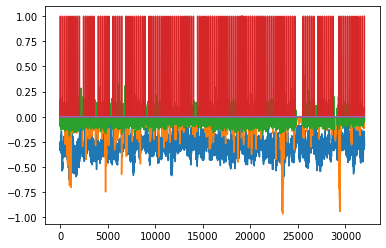

In [159]:
no=2
plt.plot(-totansfps[no])
plt.plot(-totanspl[no])
plt.plot(totch[no])
plt.plot(totmappl[no])
plt.plot(totmapfps[no])
print(counted[no])
print(np.corrcoef(totmapfps[no],totanspl[no]))
print(np.corrcoef(totmapfps[no],totansfps[no]))
#plt.xlim(4000,5000)
corr(np.asarray(totmappl), np.asarray(totmapfps), np.asarray(totanspl), np.asarray(totansfps))
plt.show

In [37]:

pks= what_the_peak(f2, predp2, chunks, 1)
print(pks)


[595.14002025]


C:\Program Files\Python39\lib\site-packages\numpy\core\fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Program Files\Python39\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


TypeError: object of type 'numpy.float64' has no len()

[331.60330502 210.59347227  59.73691823  91.93949551 124.914938
   7.00820832   8.71979923]


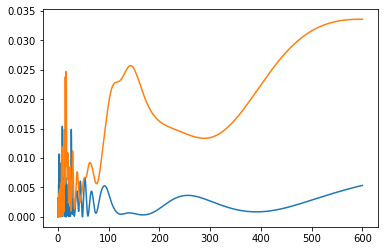

In [33]:
plt.plot(f1,predp1)
plt.plot(f2,predp2)
#plt.scatter(pks,np.zeros(len(pks)), color='green')
#print(pks)
print(np.asarray(tdur))
#plt.xlim(0,35)

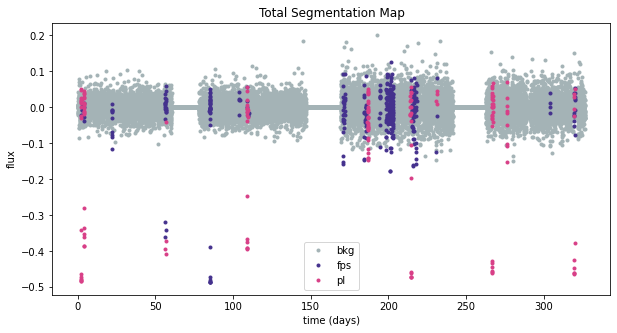

In [34]:
#chunks=np.append(chunks, [np.zeros(4000)], axis=0)
plot_a_map(chunks2,opchunk)
#plt.ylim(-0.005,0.01)
#plt.savefig('fprez_example3_raw.png')

plt.show()

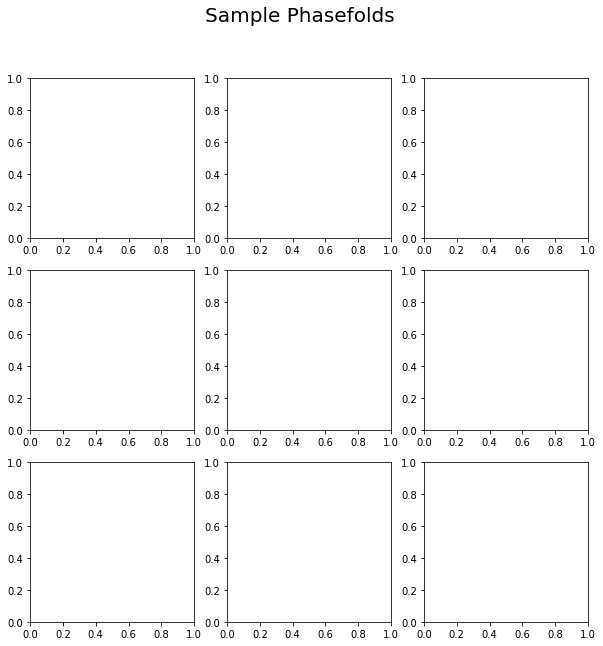

In [36]:
plot_a_peak(pks,chunks,
    opchunk[:,:,0],[0.3,0.3,0.1,0.0,0.0,0.0,0.2,0.2,0.0], num1=3, num2=3,scale=1*np.ones(9), thres=0.2)

#plt.savefig('fprez_example3_peak.png') 
plt.show()


[14.818481848184819]


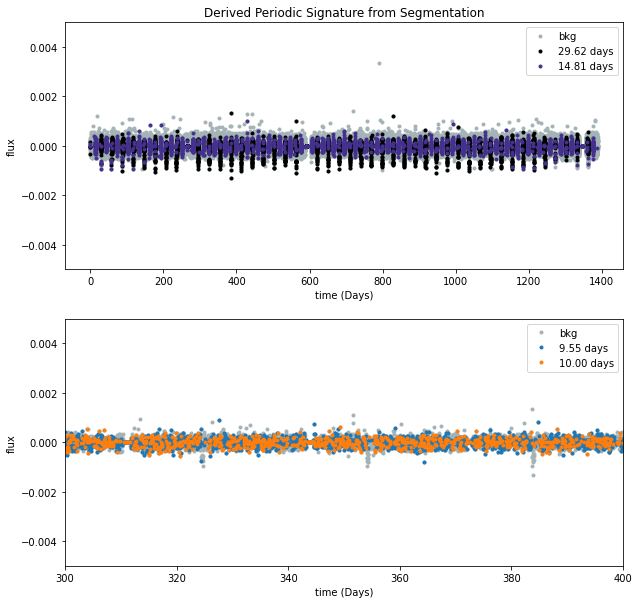

In [46]:
#ch=[29.62,14.81,9.55,10]
ch=pks
mask = color_a_peak(chunks,ch, [0.5,0.5,0.05,0.21])
#print(np.asarray(mask).shape)



fig,ax=plt.subplots(2,1, figsize=(10,10))

ax[0].set_title('Derived Periodic Signature from Segmentation')
ax[0].set_xlabel('time (Days)')
ax[0].set_ylabel('flux')
ax[1].set_xlabel('time (Days)')
ax[1].set_ylabel('flux')
ax[0].set_ylim(-0.005,0.005)
ax[1].set_ylim(-0.005,0.005)
print(pks)

val = np.concatenate(chunks)
xaxis = np.arange(0,len(val),1)*29.4/1440
#print(pks)
ax[0].plot(xaxis,val, ls='none', marker='.', color='#a4b3b6', label='bkg')
ax[1].plot(xaxis,val, ls='none', marker='.', color='#a4b3b6', label='bkg')

ax[0].plot(np.asarray(mask[0])*29.4/1440,val[mask[0]], ls='none', marker='.',color='black',label= "{:.2f}".format(ch[0])+' days')
other = np.setdiff1d(mask[1],mask[0])
ax[0].plot(other*29.4/1440,val[other], ls='none',marker='.',color='#44318d',label= "{:.2f}".format(ch[1])+' days')
other = np.setdiff1d(mask[2],mask[0])
other = np.setdiff1d(other,mask[1])
ax[1].plot(other*29.4/1440,val[other], ls='none', marker='.',label= "{:.2f}".format(ch[2])+' days')
other = np.setdiff1d(mask[3],mask[2])
other = np.setdiff1d(other,mask[1])
other = np.setdiff1d(other,mask[0])
ax[1].plot(other*29.4/1440,val[other], ls='none', marker='.',label= "{:.2f}".format(ch[3])+' days')
'''other = np.setdiff1d(mask[2],mask[3])
other = np.setdiff1d(other,mask[2])
other = np.setdiff1d(other,mask[1])
other = np.setdiff1d(other,mask[0])'''
#plt.plot(other,val[other], ls='none', marker='.')
#other = np.setdiff1d(mask[5],mask[4])
#other = np.setdiff1d(other,mask[3])
#other = np.setdiff1d(other,mask[2])
#other = np.setdiff1d(other,mask[1])
#other = np.setdiff1d(other,mask[0])
#plt.plot(other,val[other], ls='none', marker='.')
#other = np.setdiff1d(mask[4],mask[3])
#plt.plot(other,val[other], ls='none', marker='.')
#other = np.setdiff1d(mask[5],mask[4])
#plt.plot(other,val[other], ls='none', marker='.')
#plt.plot(other,val[other], ls='none', color='gray',marker='.')
#ax[0].set_xlim(100,800)
ax[1].set_xlim(300,400)

ax[0].legend()
ax[1].legend()
#plt.savefig('fprez_example5.png')
plt.show()

In [104]:
#Now we try running it on some of the test samples, and hopefully try to put a number on the accuracy ...
#give a trial run out of the maximum peak of LS periodogram... dont think its gonna work but still
chunkarrs, perarrs,label, idarr = gc.read_tfr_record('../../training_data/tstest',
    ['input','period','label','id'],['ar','ar','ar','b'],[tf.float32, tf.float32, tf.bool, tf.string])


    


In [ ]:
i=0
for el in chunkarrs[:10]:
    chunks = el.reshape(17,4000)
    chunks = np.asarray([np.tanh(100*row) for row in chunks])
    opchunk = convNN.predict(chunks)
    p, predf = periodogram_and_freq(opchunk[:,:,0],1, 68000*29.4/1440)
    #pks,maxm = what_the_peak(p, predf, opchunk[:,:,0], 1)
    p2, predf2 = periodogram_and_freq(opchunk[:,:,1],1, 68000*29.4/1440)
    #pks,maxm2 = what_the_peak(p, predf, opchunk[:,:,1], 1)
    print(max(predf),max(predf2),label[i])
    i+=1

b'011619964' [False  True False]


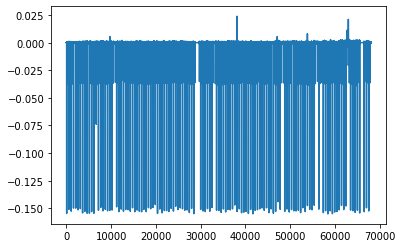

In [106]:
plt.plot(chunkarrs[1])
print(idarr[1],label[1])

In [17]:
#wholesome thing.... lets see if this is any better
entries = os.listdir(PATH2)
corrects = 0 
incorrects = 0
cm=[[0,0],[0,0]]

for el in entries:
    ip,tp,pp,sm,ss = gc.read_tfr_record(PATH2+el,
        ['input','true_map','pred_map','scale_median','scale_std'],
        ['ar','ar','ar','fl','fl'], 
        [tf.float32, tf.bool, tf.float32, tf.float32, tf.float32])

    pp = np.reshape(pp,(len(tp),4000,3))
    tp = np.reshape(tp,(len(tp),4000,3))

    totpp = np.concatenate(pp, axis=0)
    tottp = np.concatenate(tp, axis=0)

    #print(np.mean(totpp, axis=0))
    #print(totpp.shape)
    #planet detection:
    if(np.any(tottp[:,0]>0)):
        val1 = np.corrcoef(totpp[:,1], tottp[:,0])
        val2 = np.corrcoef(totpp[:,0], tottp[:,0])
        if(val2[0,1]>val1[0,1]): 
            cm[0][0]+=1
            corrects+=1
        else: 
            cm[1][0]+=1
            incorrects+=1
        #print(val1[0,1], val2[0,1])
    
    #fps detect
    if(np.any(tottp[:,1]>0)):
        val1 = np.corrcoef(totpp[:,1], tottp[:,1])
        val2 = np.corrcoef(totpp[:,0], tottp[:,1])
        if(val1[0,1]>val2[0,1]): 
            cm[1][1]+=1
            corrects+=1
        else: 
            cm[0][1]+=1
            incorrects+=1
    
print(corrects, incorrects)
print(corrects/(corrects+incorrects))
print(cm/np.asarray(cm).sum())

867 465
0.6509009009009009
[[0.37912913 0.33108108]
 [0.01801802 0.27177177]]


In [9]:
#wholesome thing.... lets see if this is any better
entries = os.listdir (PATH2)
trues=[]
predicts=[]

for el in entries:
    ip,tp,pp,sm,ss = gc.read_tfr_record(PATH2+el,
        ['input','true_map','pred_map','scale_median','scale_std'],
        ['ar','ar','ar','fl','fl'], 
        [tf.float32, tf.bool, tf.float32, tf.float32, tf.float32])

    pp = np.reshape(pp,(len(tp),4000,3))
    tp = np.reshape(tp,(len(tp),4000,3))

    totpp = np.concatenate(pp, axis=0)
    tottp = np.concatenate(tp, axis=0)
    
    #planet detection:
    ftp = np.fft.fft(np.around(totpp[:,0]))
    ftfp = np.fft.fft(np.around(totpp[:,1]))

    if(max(np.abs(ftp[1:]))<max(np.abs(ftfp[1:]))): predicts.append(1)
    else: predicts.append(0)
    
    if(tottp[:,0].sum()<tottp[:,1].sum()): trues.append(1)
    else: trues.append(0)
    

cm=confusion_matrix(np.asarray(trues),np.asarray(predicts))
print(cm/cm.sum())

[[0.18022814 0.21444867]
 [0.1026616  0.5026616 ]]
